In [3]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

courses_data = pd.read_csv('/Users/subu/Desktop/Subu/Duke/DESIGNTK_530/designtk-530-f1/courses.csv')
courses_data.head()

,Unnamed: 0,key,prefix,number,suffix,title,description,minimum credits,maximum credits,other
0,0,ACCTG 151,ACCTG,151,NaN,Introductory Financial Accounting I,"Basic concepts, principles, and practices for ...",3,3,NaN
1,1,ACCTG 152,ACCTG,152,NaN,Introductory Financial Accounting II,"Accounting for partnerships, corporations, cas...",3,3,Enforced Prerequisite at Enrollment: ACCTG 151
2,2,ACCTG 199,ACCTG,199,NaN,Foreign Studies,Courses offered in foreign countries by indivi...,1,12,International Cultures (IL)
3,3,ACCTG 211,ACCTG,211,NaN,Financial and Managerial Accounting for Decisi...,Introduction to the role of accounting numbers...,4,4,Enforced Prerequisite at Enrollment: MATH 21 o...
4,4,ACCTG 211H,ACCTG,211,H,Financial and Managerial Accounting for Decisi...,The objective of this course is to introduce s...,4,4,Enforced Prerequisite at Enrollment: MATH 21 o...


In [4]:
# Data Cleaning
# Handling missing descriptions, replacing NaN with empty string
courses_data['description'] = courses_data['description'].fillna('')

# Filtering out courses with 0 credits
courses_clean = courses_data[courses_data['minimum credits'] > 0].copy()

# Categorizing courses by workload based on credits
def categorize_credits(credits):
    if credits <= 2:
        return 'Low'      # Low-effort courses (1-2 credits)
    elif credits == 3:
        return 'Standard' # Standard courses (3 credits - most common)
    else:
        return 'High'     # High-effort courses (4+ credits)

courses_clean['credit_category'] = courses_clean['minimum credits'].apply(categorize_credits)

print("Credit category distribution:")
print(courses_clean['credit_category'].value_counts())

Credit category distribution:
credit_category
Standard    5728
Low         2690
High         564
Name: count, dtype: int64


In [18]:
# Combining title + description for text features because titles often contain 
# key subject matter (e.g., "Intro to Machine Learning") and descriptions provide 
# context about content and skills
courses_clean['text'] = courses_clean['title'].fillna('') + ' ' + courses_clean['description'].fillna('')

# Setting up TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=300,
    min_df=5,
    max_df=0.8,
    stop_words='english',
    ngram_range=(1, 2)  # Including both single words and 2-word phrases (e.g., "machine learning", "public speaking")
)

# Fitting and transforming text to numerical features
X_text = tfidf.fit_transform(courses_clean['text'])

print(f"Converted text to {X_text.shape[1]} features across {X_text.shape[0]} courses")

# Checking what the most important words are
feature_names = tfidf.get_feature_names_out()
print(f"Sample features (words/phrases the model will use):")
print(feature_names[:30])

Converted text to 300 features across 8982 courses
Sample features (words/phrases the model will use):
['ability' 'able' 'activities' 'activity' 'addition' 'advanced' 'african'
 'american' 'analysis' 'analyze' 'ancient' 'application' 'applications'
 'applied' 'apply' 'approach' 'approaches' 'appropriate' 'areas' 'art'
 'arts' 'arts degree' 'aspects' 'assessment' 'assignments' 'ba'
 'ba course' 'bachelor' 'bachelor arts' 'based']


In [19]:
# Preparing data for Credit Prediction
X_credits = X_text  # Using TF-IDF features
y_credits = courses_clean['credit_category']  # Target: Low/Standard/High

# Splitting into training (80%) and testing (20%) sets
# Training set = model learns patterns
# Testing set = evaluating how well model generalizes to unseen courses
X_train_credits, X_test_credits, y_train_credits, y_test_credits = train_test_split(
    X_credits, y_credits, test_size=0.2, random_state=42, stratify=y_credits
)

print(f"Training set: {X_train_credits.shape[0]} courses")
print(f"Testing set: {X_test_credits.shape[0]} courses")
print(f"\nTraining set distribution:")
print(y_train_credits.value_counts())

Training set: 7185 courses
Testing set: 1797 courses

Training set distribution:
credit_category
Standard    4582
Low         2152
High         451
Name: count, dtype: int64


In [20]:
# Training Random Forest model
rf_credits = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=20)
rf_credits.fit(X_train_credits, y_train_credits)

# Making predictions on test set
y_pred_credits = rf_credits.predict(X_test_credits)

# Evaluating performance
accuracy = accuracy_score(y_test_credits, y_pred_credits)
print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 87.20%


In [21]:
import pickle

pickle.dump(rf_credits, open("pickles/random_forest_course_credits.pkl", "wb"))

In [22]:
vectorizer = tfidf
course_vectors = X_text

pickle.dump(vectorizer, open("pickles/tfidf_vectorizer.pkl", "wb"))
pickle.dump(course_vectors, open("pickles/course_vectors.pkl", "wb"))

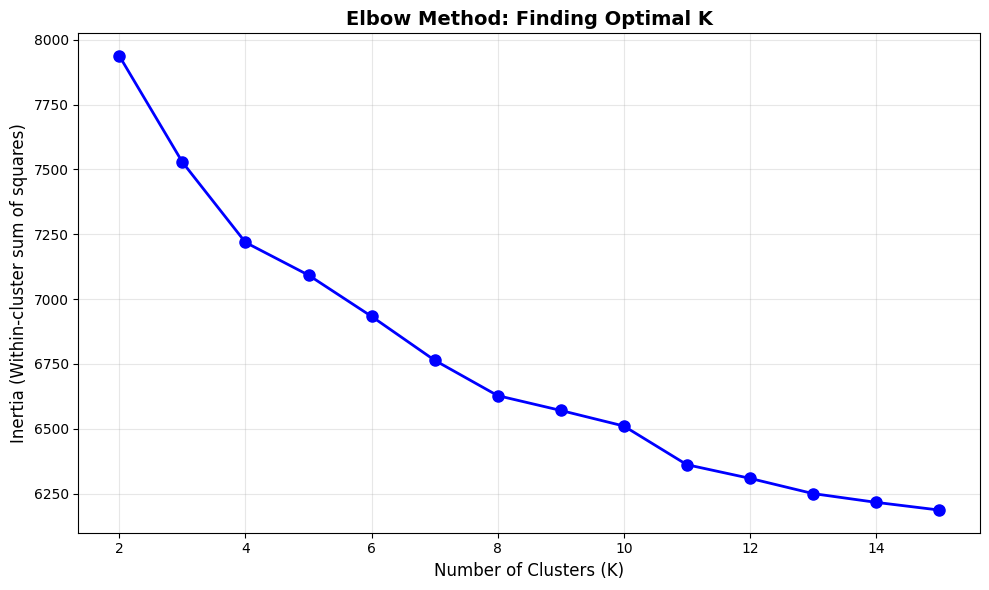

In [23]:
# Making a unsupervised model using K-Means

# Finding optimal number of clusters using Elbow Method
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

inertias = []
K_range = range(2, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_text)
    inertias.append(kmeans.inertia_)

# Plotting elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
plt.title('Elbow Method: Finding Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('elbow_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Applying K-Means with optimal K=8

optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
courses_clean['cluster'] = kmeans.fit_predict(X_text)

print(f"Cluster distribution:")
print(courses_clean['cluster'].value_counts().sort_index())

Cluster distribution:
cluster
0    1813
1     560
2     201
3    4646
4     381
5     604
6     433
7     344
Name: count, dtype: int64


In [31]:
courses_clean.to_csv("courses_with_cluster.csv")

In [25]:
pickle.dump(kmeans, open("pickles/k_means_course_clusters.pkl", "wb"))